In [4]:
'''
This notebook should generate Main Figure 1 and 5
which shows:
expected relative changes in mean mutation rate, 
variance in relative mean mutation rates, 
variance in relative mean mutation rates given a fixed expected mutation rate,
variance in relative mutation rates within a population given a fixed expected mutation rate.
These results are both simulated and numerically calculated.
'''

'\nThis notebook should generate Main Figure 1 and 5\nwhich shows:\nexpected relative changes in mean mutation rate, \nvariance in relative mean mutation rates, \nvariance in relative mean mutation rates given a fixed expected mutation rate,\nvariance in relative mutation rates within a population given a fixed expected mutation rate.\nThese results are both simulated and numerically calculated.\n'

In [5]:
import numpy as np
%matplotlib inline
import matplotlib as mpl

from matplotlib import lines as mlines
from matplotlib import pyplot as plt
import seaborn as sns
from collections import namedtuple as nt
from collections import defaultdict as ddict
from collections import OrderedDict as odict
from copy import deepcopy
import pickle
import os

import sys
sys.path.append("./../") # adds parent directory to path
import stationary_distribution_aug as sd
import mutator_classes as mc

In [6]:
sns.set_style('whitegrid')

font_size = 10
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 10

black = np.array([0,0,0])
purple = np.array([0.7,0,0.7])

In [7]:
result_tuple = nt('result_tuple',['s','mean','mean_err','variance','variance_err','within','within_err','phi','params','m'])

In [8]:
def standard_error(i,n):
    return i/(n**0.5)

def get_s(p):
    s = 4*p.N*p.h*p.s*p.loci*p.phi
    return s

def process_analyzed_results(f):
    
    # load data
    try:
        with open(f+'_fixed','rb') as fin:
            r = pickle.load(fin)
    except FileNotFoundError:
        with open(f,'rb') as fin:
            r = pickle.load(fin)
     
    # get the sampled mutator frequencies
    chosen_values = list(list(r.values())[0][4].values())[0]['var']
    
    # get the paramters
    p = list(r.keys())[0]
    s = get_s(p)
    m = p.M
    phi = p.phi
    
    # get expected values
    (statdist,p,params) = calc_exp_results(p,s)
    frequency_mean      = sum(i*q for i,q in statdist.items())
    frequency_variance  = sum(i**2*q for i,q in statdist.items()) - frequency_mean**2
    
    # summarize data
    all_values = []
    variance_error = []
    mean_error = []
    within_error = []
    
    for i in chosen_values:
        all_values.extend(i)
        variance_error.append(np.var(i))
        within_error.append(np.mean([j*(1-j) for j in i])*2)
        mean_error.append(np.mean(i))
    
    all_values = np.array(all_values)
    
    mean = np.mean(all_values)
    mean_err = np.std(mean_error)
    
    within = np.mean(all_values*(1-all_values)*2)
    within_err = np.std(within_error)
    
    variance = np.var(all_values)
    variance_err = np.std(variance_error)

    num_trials = len(variance_error)
    
    mean_err     = standard_error(mean_err,num_trials)
    variance_err = standard_error(variance_err,num_trials)
    within_err   = standard_error(within_err,num_trials)
    
    return result_tuple(s            = s,
                       mean         = mean,
                       mean_err     = mean_err,
                       variance     = variance,
                       variance_err = variance_err,
                       within       = within,
                       within_err   = within_err,
                       phi          = phi,
                       params       = p,
                       m            = m)
    

In [9]:
result_tuple_exp = nt('result_tuple',['s','mean','variance','within','segregating','phi','params'])

def create_result_tuple_exp(l):
    
    return result_tuple_exp(s = l[0],
                        mean=l[1],
                        variance = l[2],
                        within = l[3],
                        segregating = l[4],
                        phi = l[5])

def get_phi(s,p):
    phi = s/(4*p.N*p.h*p.s*p.loci)
    return phi

def calc_exp_results(params,s):
    
    params.phi = get_phi(s,params)
    
    statdist = sd.get_SD(params)
    
    return (statdist,deepcopy(params))

def process_exp(s,statdist,params,rdict):
    
    frequency_mean      = sum(i*p for i,p in statdist.items())
    frequency_variance  = sum(i**2*p for i,p in statdist.items()) - frequency_mean**2
    seg_variance        = sum((i-frequency_mean)**2*p for i,p in statdist.items() if i > 0 and i < 1)
    within_variance     = sum(2*i*(1-i)*p for i,p in statdist.items())
    
    rdict[s] = result_tuple_exp(s           = s,
                                mean        = frequency_mean,
                                variance    = frequency_variance,
                                within      = within_variance,
                                segregating = seg_variance,
                                phi         = params.phi,
                                params      = params)
    

In [11]:
params = mc.Parameters(h=1, s=0.005, N=2000, loci=24000000.0, mutation_rate=6.25e-08, M=10, phi=1e-8, mutator_mutation_rate=1.25e-07)

exp_results = odict()

s_values = np.logspace(-2,3,100)
calc_exp_statdist = {}
for s in s_values:
    calc_exp_statdist[s] = calc_exp_results(params,s)

for s,(statdist,new_params) in calc_exp_statdist.items():
    process_exp(s,statdist,new_params,exp_results)

In [12]:
in_dir = '/Users/will_milligan/PycharmProjects/Mutator_Project/Final Figs/052020_Scripts/scaled_sims_results/sims_01302020/DEFAULT/analysis/accepted_values'

files = os.listdir(in_dir)

results = {}
for f in files:

    M = eval(os.path.basename(f).split('_T')[1].split('_')[0])
    S = eval(os.path.basename(f).split('_S')[1].split('_')[0])
    
    if M not in results.keys():
        results[M] = {}
    
    results[M][S] = process_analyzed_results(f)

In [16]:
def get_observed_results(results):
    
    s_values   = np.sort(np.array(list(results.keys())))
#     s_values   = np.array([results[s].s for s in s_values])
    phi        = np.array([results[s].phi for s in s_values])
    mean_freq  = np.array([results[s].mean for s in s_values])
    mean_err   = np.array([results[s].mean_err for s in s_values])
    var_freq   = np.array([results[s].variance for s in s_values])
    var_err    = np.array([results[s].variance_err for s in s_values])
    within     = np.array([results[s].within for s in s_values])
    within_err = np.array([results[s].within_err for s in s_values])
    
    return (s_values,phi,mean_freq,mean_err,var_freq,var_err,within,within_err)
    

In [17]:
def common_ax_modifications(ax,
                            title = '',
                            xlabel = 'Scaled selection parameter ' + r'$\left( 4NLhs\phi\right)$',
                            ylabel = '',
                            xscale = 'log',
                            yscale = 'log',
                            ylim = None,
                            xlim = None):
    
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title,pad=10)
    
    ax.set_xticks(np.logspace(-2,3,6))
    if ylim:
        ax.set_ylim(ylim)
    
    if xlim:
        ax.set_xlim(xlim)
        
    ax.grid([0.95*3])
    
    plt.sca(ax)
    plt.tick_params(bottom=True, top=False, left=True, right=False)
    plt.tick_params(bottom=True, top=False, left=True, right=False,which='minor')
    plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

In [23]:
def mean_mutation_rate_figure(fig,ax,results,exp_results,Mcolors,Mmarkers):
    
    legend_entries = {}

    for M,Mdict in results.items():
        
        for S,observed_rt in Mdict.items():
             
            ax.errorbar(observed_rt.s,
                        2*M*observed_rt.mean*(observed_rt.phi),
                        2*M*observed_rt.mean_err*(observed_rt.phi),
                        color=Mcolors[M],
                        ls='None',
                        marker=Mmarkers[M])                                                               
    
    for M in np.logspace(1,4,4):
        ax.plot([exp_rt.s for exp_rt in exp_results.values()],
                 [2*M*exp_rt.mean*exp_rt.phi for exp_rt in exp_results.values()],
                 color=colors[M],
                 ls = '-')

        ax.text(x = 0.6e-2,
                 y = 2*M*exp_results[1e-2].mean*(exp_results[1e-2].phi),
                 s = f'$10^{int(np.log10(M))}$ Modifiers',
                 color = Mcolors[M],
                 size = font_size,
                 rotation = 39)
        
    ax_title = r'$\bf{A.}$ Increase in expected mutation rate from modifiers'
    ax_ylabel = 'Increase in expected rate ' + r'$\left(E(\Delta u)\right)$'
    
    common_ax_modifications(ax,title=ax_title,ylabel=ax_ylabel)

    legend_entries['Analytic approx.']=mlines.Line2D([], [], color='k',ls='-')
    legend_entries['Simulation\nmean'+ r' $\pm$ 2 SEs']=plt.errorbar([],[],[],ls='None',marker='.',color='k')
    
    location = 'lower left'
    plt.legend(legend_entries.values(),
               legend_entries.keys(),
               fontsize = 9, 
               ncol=1,
               edgecolor='k',
               framealpha=1,
               loc=location,
               labelspacing = 0.3,
               handletextpad = 0.5,
               handlelength = 1.5,
               borderaxespad = 0.3,
               borderpad = 0.3)

In [26]:
def variance_mutation_rate_figure(fig,ax,results,exp_results,Mcolors,Mmarkers):
    
    legend_entries = {}

    for M,Mdict in results.items():
        
        for S,observed_rt in Mdict.items():
              
            ax.errorbar(observed_rt.s,
                        4*M*observed_rt.variance*(observed_rt.phi)**2,
                        4*M*observed_rt.variance_err*(observed_rt.phi)**2,
                        color=Mcolors[M],
                        ls='None',
                        marker=Mmarkers[M] )       
            
    for M in np.logspace(1,4,4):
        ax.plot([exp_rt.s for exp_rt in exp_results.values()],
                [4*M*exp_rt.variance*(exp_rt.phi)**2 for exp_rt in exp_results.values()],
                color=colors[M],
                ls = '-')
    
    ax_title = r'$\bf{B.}$ Variance in mean mutation rate from modifiers'
    ax_ylabel = 'Variance in mean rate '+ r'$ \left( V(\bar{u}) \right) $'
    
    common_ax_modifications(ax,title=ax_title,ylabel=ax_ylabel)
    

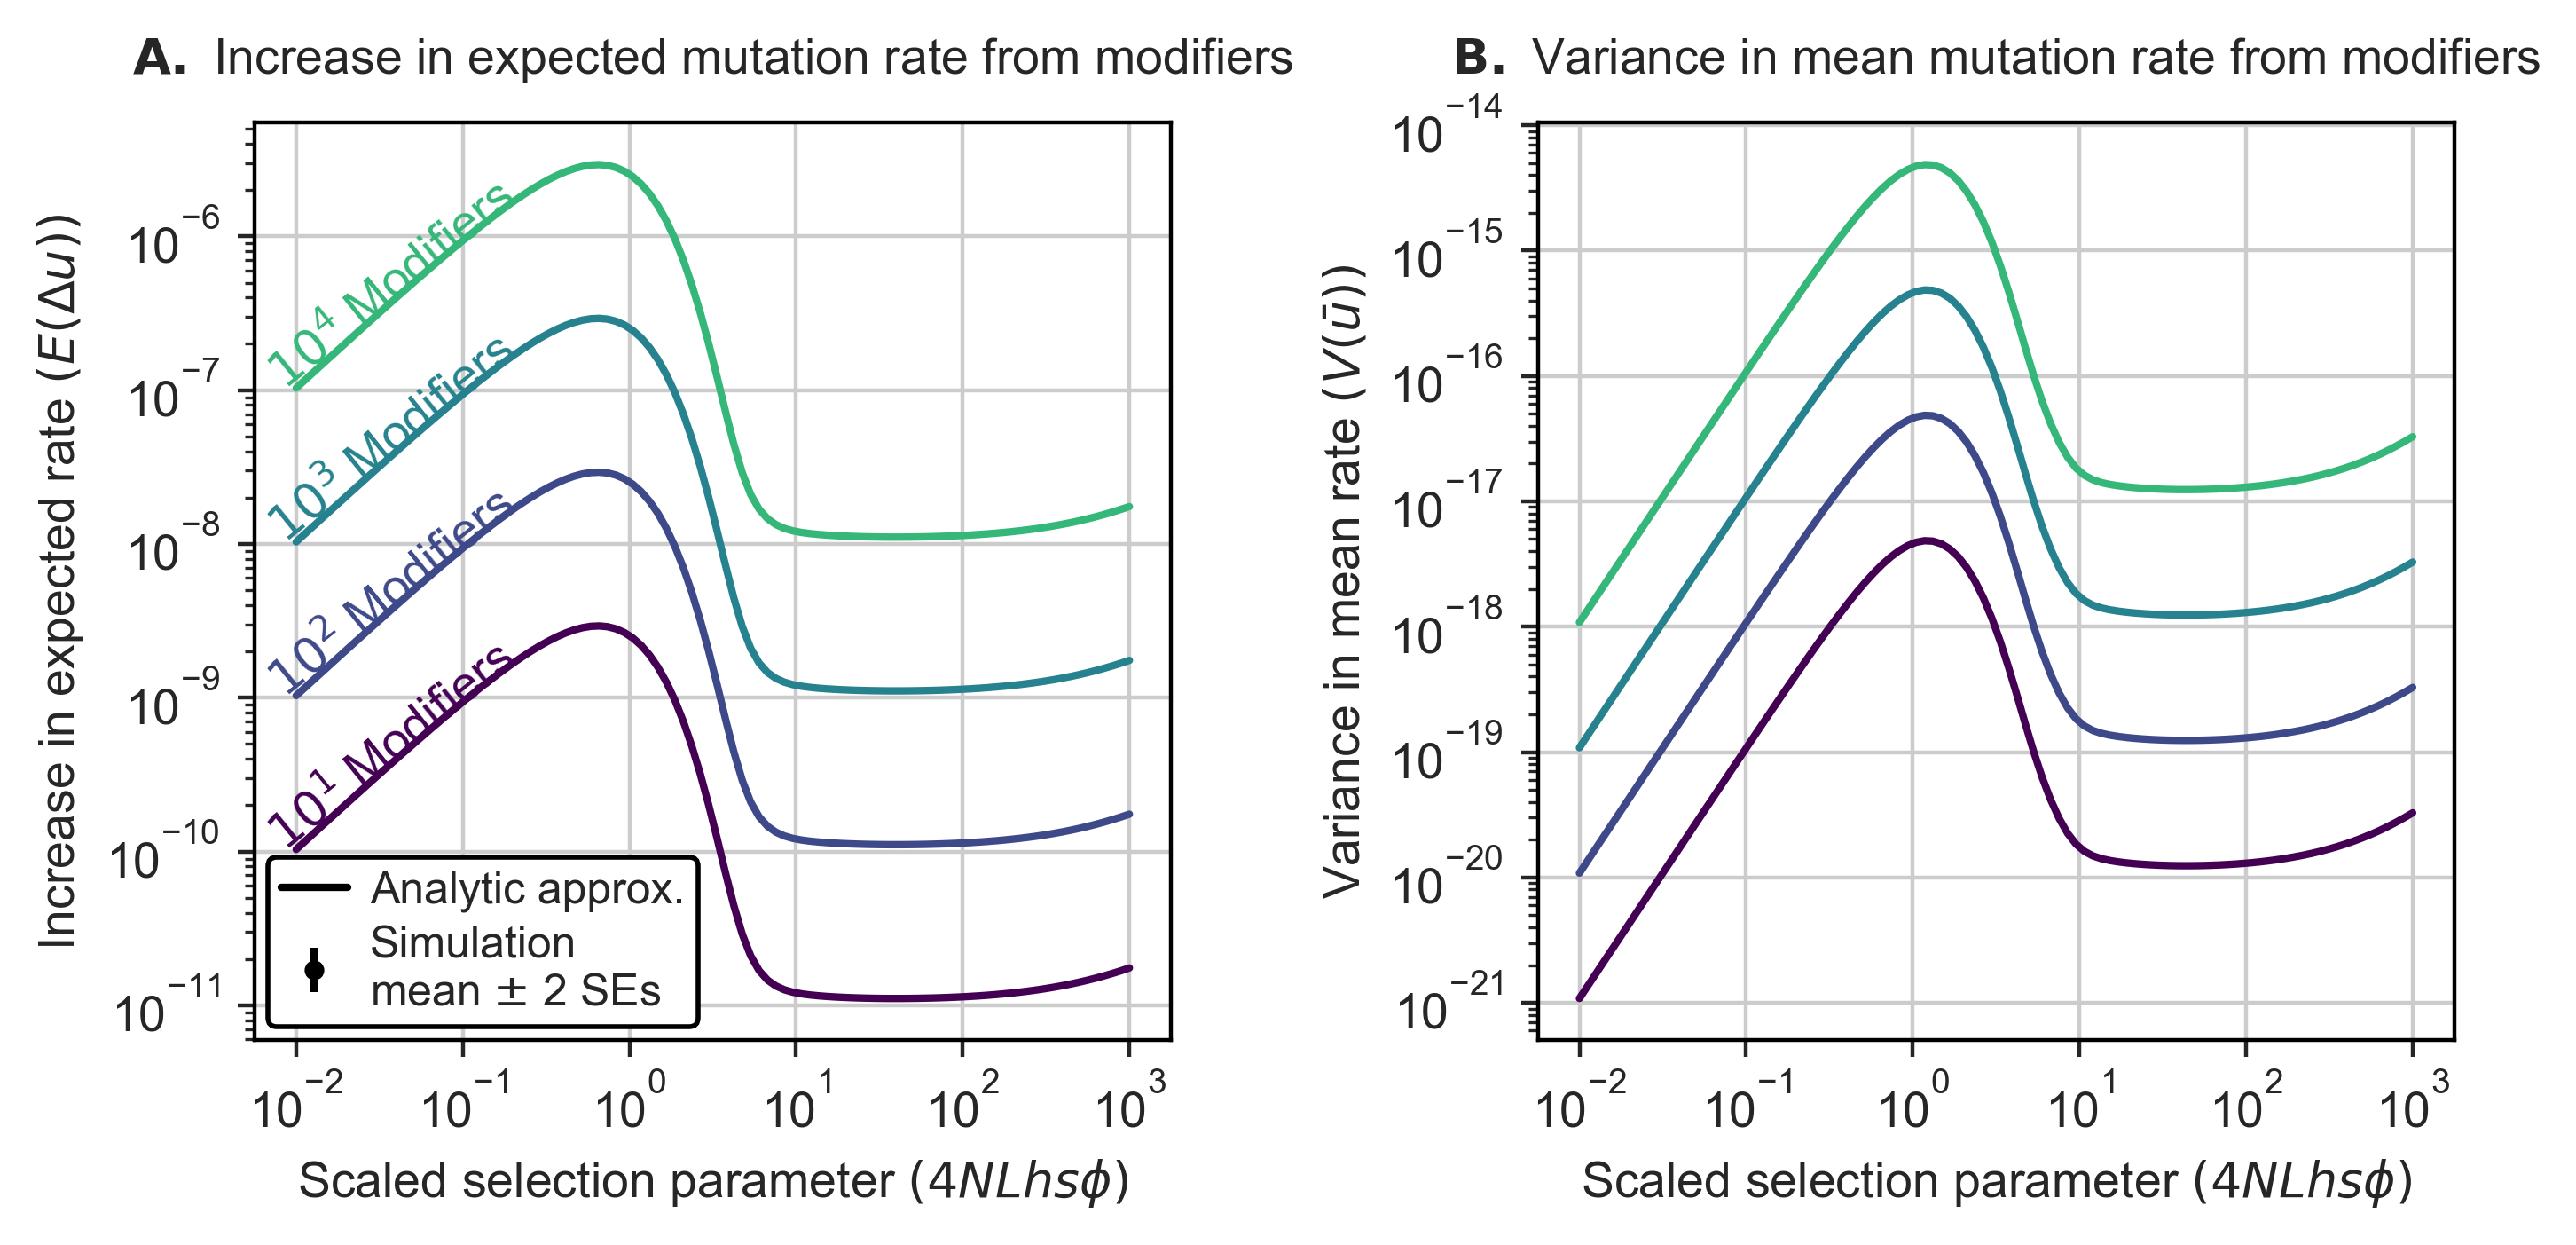

In [27]:
fig, (ax1,ax2) = plt.subplots(figsize=(8,3.54),nrows=1,ncols=2,dpi=400)

cmap = mpl.cm.get_cmap('viridis')
colors = {M:cmap(i) for M,i in zip([10,100,1000,10000],np.linspace(0,2/3,4))}
markers = {10:'.',100:'.',1000:'.',10000:'.'}

mean_mutation_rate_figure(fig,ax1,results,exp_results,colors,markers)
variance_mutation_rate_figure(fig,ax2,results,exp_results,colors,markers)
plt.subplots_adjust(wspace=0.4,bottom = 0.15)

In [29]:
coral = [.973, .414, .575]
teal = [0,0.55,0.55]
charcoal = [0.3,0.3,0.3,1]
light_grey=[0.65,0.65,0.65,1]
mpl.rcParams['legend.fontsize'] = 9.5
line_weight = 2
location = 'lower right'
label_font_size = 9.5
fixed_mutation_rate = 1.25e-7

In [45]:
def within_population_variance(fig,ax,results,exp_results,M=1000,relative_factor = 1.25e-7):
    
    
    # expected values
    x_values = np.array([exp_rt.s for exp_rt in exp_results.values()])
    within_values = np.array([exp_rt.within*(exp_rt.phi)**2 for exp_rt in exp_results.values()])/relative_factor**2
    between_values = np.array([4*exp_rt.variance*(exp_rt.phi)**2 for exp_rt in exp_results.values()])/relative_factor**2
    
    # variance between
    ax.plot(x_values,
            between_values,
            color=light_grey,
            ls = '-')
    
    # variance within
    ax.plot(x_values,
            within_values,
            ls = '-',
            color = charcoal,
            lw = line_weight)
    
    # Mutation-Selection balance
    ax.plot(x_values[x_values>1],
            2*(np.array([exp_rt.phi for exp_rt in exp_results.values() if exp_rt.s > 1]))**2*2*params.N*params.mutator_mutation_rate/(x_values[x_values>1])/relative_factor**2,
            ls=':',
            color = coral,lw=line_weight)
    
    #neutral theory
    ax.plot(x_values[x_values<=1],
             2*(np.array([exp_rt.phi for exp_rt in exp_results.values() if exp_rt.s <= 1]))**2*2*params.N*params.mutator_mutation_rate/relative_factor**2,
             label='Neutral Theory',
             ls='--',
             color = teal,lw=line_weight)
    
    # plot observed results from simulations
    s_values,phi, mean_freq, mean_err, var_freq, var_err, within, within_err = get_observed_results(results[M])
    legend_entries = {}
    legend_entries[r'Simulated mean $\pm$ 2 SEs'.format(int(np.log10(M)))]=ax.errorbar(10**s_values,
                                                                                    within*(phi)**2/relative_factor**2,
                                                                                    within_err*(phi)**2/relative_factor**2,
                                                                                    color=charcoal,
                                                                                    zorder=1,
                                                                                    ls='None',
                                                                                    markersize = 5, 
                                                                                    marker='^')
    # stuff to make the legend and make graph look pretty
    legend_entries[r'Stationary distribution'] = mlines.Line2D([], [], color=charcoal,ls='-')
    common_ax_modifications(ax,
                            title = r'$\bf{A.}$ Variance from one modifier site',
                            ylabel = 'Relative variance within a population')
    
    plt.sca(ax)
    plt.legend(legend_entries.values(),
               legend_entries.keys(),
               ncol=1,
               edgecolor='k',
               framealpha=1,
               loc=location)
    plt.text(x = 1e-2, 
             y = 3.7e-8/2.5*4,
             s = 'Variance between\n    populations',
             rotation = 52, 
             size = label_font_size,
             color = 'grey')
    plt.text(x = 0.2e-1, 
             y = 0.8e-9,
             s = r'$\bar{\pi}(\phi) \approx 4N\mu$',
             rotation = 54, 
             size = label_font_size,
             color = teal)
    plt.text(x = 4.5, 
             y = 3.5e-6,
             s = r'$\bar{\pi}(\phi) \approx \mu / Lhs\phi$',
             rotation = 34.5, 
             size = label_font_size,
             color = coral)


def within_population_variance_M(fig,ax,results,exp_results,M=1000,relative_factor=1.25e-8**2):
    
    line_weight = 2
    
    # expected values
    x_values = np.array([exp_rt.s for exp_rt in exp_results.values()])
    nvals_exp = np.array([fixed_mutation_rate/(2*exp_rt.mean*exp_rt.phi) for exp_rt in exp_results.values()])
    within_values = np.array([exp_rt.within*(exp_rt.phi)**2 for exp_rt in exp_results.values()])*nvals_exp/relative_factor
    between_values = np.array([4*exp_rt.variance*(exp_rt.phi)**2 for exp_rt in exp_results.values()])*nvals_exp/relative_factor

    ax.plot(x_values,
            between_values,
            color=light_grey,
            ls = '-')
    
    ax.plot(x_values,
            within_values,
            ls = '-',
            color = charcoal,
            lw = line_weight)
    
    ax.plot(x_values[x_values>1],
            nvals_exp[x_values>1]*2*(np.array([exp_rt.phi for exp_rt in exp_results.values() if exp_rt.s > 1]))**2*2*params.N*params.mutator_mutation_rate/relative_factor/(x_values[x_values>1]),
            ls=':',
            color = coral,lw=line_weight)
    
    ax.plot(x_values[x_values<=1],
             nvals_exp[x_values<=1]*2*(np.array([exp_rt.phi for exp_rt in exp_results.values() if exp_rt.s <= 1]))**2*2*params.N*params.mutator_mutation_rate/relative_factor,
             label='Neutral Theory',
             ls='--',
             color = teal,lw=line_weight)
    
    # expected values
    s_values,phi, mean_freq, mean_err, var_freq, var_err, within, within_err = get_observed_results(results[M])
    phi = np.array([results[M][s].phi for s in s_values])
    nvals =  fixed_mutation_rate/(2*mean_freq*phi)
    
    ax.errorbar(10**s_values,
                 within*(phi)**2*nvals/relative_factor,
                 2*within_err*(phi)**2*nvals/relative_factor,
                 color=charcoal,
                 marker='^',
                 markersize=5,
                 ls='None',
                 zorder=1)

    common_ax_modifications(ax,
                            title = r'$\bf{B.}$ Variance from max. number of modifier sites',
                            ylabel = 'Relative variance within a population')
        

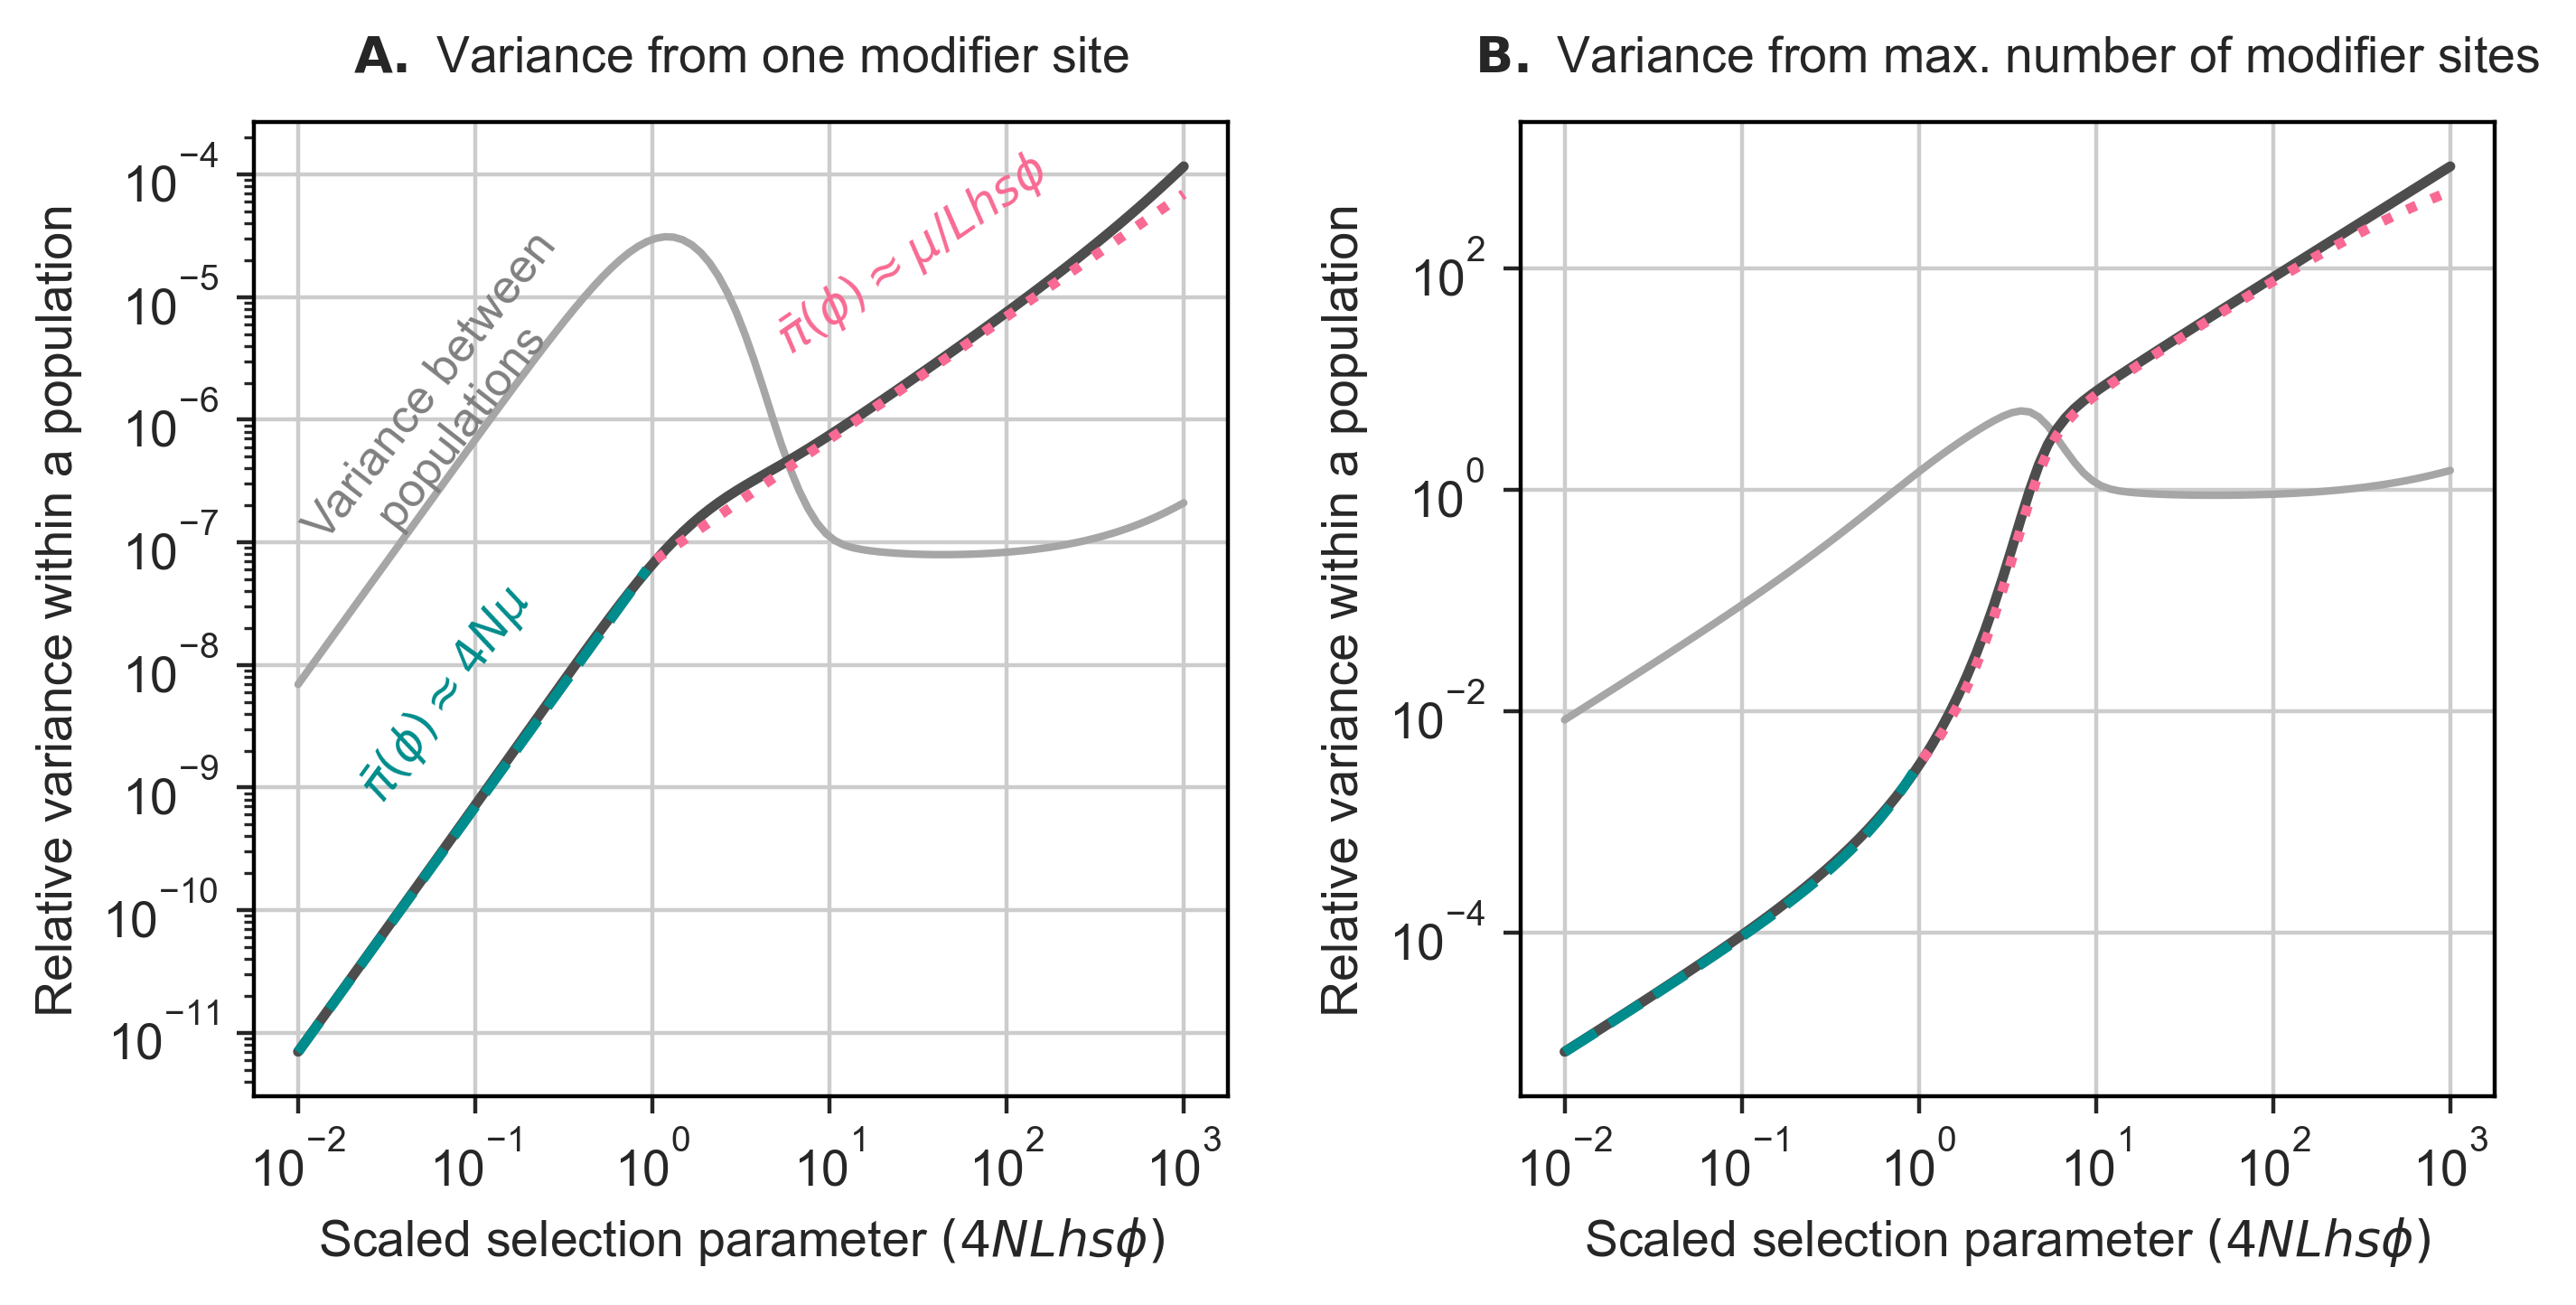

In [46]:
fig, (ax3,ax4) = plt.subplots(figsize=(4*2,3.692),nrows=1,ncols=2,dpi=400)
within_population_variance(fig,ax3,results,exp_results)
within_population_variance_M(fig,ax4,results,exp_results)
plt.subplots_adjust(hspace=0.3,wspace=0.3,bottom = 0.15)